In [1]:
# Install hdf5 library by interacting with the interpreter 
import sys
!{sys.executable} -m pip install hdf5storage
!{sys.executable} -m pip install tensorflow

# Import Libraries 
import hdf5storage
import pandas as pd
import keras
import tensorflow as tf
import numpy as np

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import ELU, PReLU, LeakyReLU
import logging
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, r2_score
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Flatten, Conv1D, MaxPooling1D, Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import logging
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as keras
import numpy as np

##libraries for LSTM

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K

from keras.layers import GRU, Flatten, Dense


## 1.) Data preprocessing

In [2]:
#load data into a variable named LOB_input
LOB_input = hdf5storage.loadmat('S092215-v50-AMZN_OCT2_states.mat')

# extract a dictionary object named 'LOB' from LOB_input and 
# convert it into a Pandas DataFrame named LOB_Amazon.
LOB_Amazon = pd.DataFrame.from_dict(LOB_input['LOB'])

In [3]:

# Label the columns
LOB_Amazon.columns = [
                      "Time", "Mid_Price", "Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]

In [4]:

def func_unix_to_timestamp(series, random_date = '2020-01-10'):
    """
    Converts a Pandas Series of Unix timestamps (in milliseconds) to human-readable timestamps.

    Args:
        series (pandas.Series): The Series of Unix timestamps to be converted.
        random_date (str, optional): The date to be used as a reference for the output timestamps.
            Defaults to '2020-01-10'.

    Returns:
        list: A list of human-readable timestamps in the format 'YYYY-MM-DD HH:MM:SS.ms'.
    """    
    new_time_column = []  # create an empty list to store converted timestamps
    for item in series:   # iterate over the input series
        current_row = datetime.datetime.fromtimestamp(item/1000.0) # convert each timestamp to datetime object
        new_time_column.append(current_row)   # add the converted timestamp to the new_time_column list

    readable_time = []                       # create an empty list to store the final formatted timestamps
    for i in range(0,len(new_time_column)):  # iterate over the converted timestamp list
        
        current_time = new_time_column[i].strftime("%H:%M:%S.%f")   # format the timestamp string
        current_time = random_date + ' ' + current_time             # concatenate the formatted string with the random date

        readable_time.append(current_time)   # add the final formatted timestamp to the readable_time list   

    # return the final list of formatted timestamps
    return readable_time

# call the function with the 'Time' column of the LOB_Amazon dataframe as input 
# and assign the output to a new variable named unix_to_timestamp
unix_to_timestamp = func_unix_to_timestamp(LOB_Amazon['Time'])
unix_to_timestamp

['2020-01-10 05:00:10.000000',
 '2020-01-10 05:00:10.000000',
 '2020-01-10 05:00:10.073000',
 '2020-01-10 05:00:10.073000',
 '2020-01-10 05:00:10.073000',
 '2020-01-10 05:00:10.073000',
 '2020-01-10 05:00:10.073000',
 '2020-01-10 05:00:10.146000',
 '2020-01-10 05:00:10.146000',
 '2020-01-10 05:00:10.395000',
 '2020-01-10 05:00:10.395000',
 '2020-01-10 05:00:10.395000',
 '2020-01-10 05:00:10.395000',
 '2020-01-10 05:00:10.467000',
 '2020-01-10 05:00:10.467000',
 '2020-01-10 05:00:10.467000',
 '2020-01-10 05:00:10.468000',
 '2020-01-10 05:00:10.468000',
 '2020-01-10 05:00:10.468000',
 '2020-01-10 05:00:10.468000',
 '2020-01-10 05:00:10.468000',
 '2020-01-10 05:00:10.541000',
 '2020-01-10 05:00:10.541000',
 '2020-01-10 05:00:10.541000',
 '2020-01-10 05:00:10.541000',
 '2020-01-10 05:00:10.541000',
 '2020-01-10 05:00:10.541000',
 '2020-01-10 05:00:10.570000',
 '2020-01-10 05:00:10.571000',
 '2020-01-10 05:00:10.574000',
 '2020-01-10 05:00:10.574000',
 '2020-01-10 05:00:10.574000',
 '2020-0

In [5]:
# Add new column to DataFrame containing human-readable timestamps

LOB_Amazon['Time'] = unix_to_timestamp 
# Convert the 'Time' column to datetime format
LOB_Amazon['Time'] = pd.to_datetime(LOB_Amazon['Time'])

# store the column names of the LOB_Amazon DataFrame in a list
lob_cols = LOB_Amazon.columns

In [6]:
# select a time period for data analysis
trade_open_close = (LOB_Amazon['Time'] >= '2020-01-10 13:00:00') \
                        & (LOB_Amazon['Time'] <= '2020-01-10 16:00:00')

# select and keep only the data within the specified time range from the LOB_Amazon DataFrame.
LOB_Amazon = LOB_Amazon[trade_open_close]

## 2) Normalization 

In [7]:
def func_scale_data(df, t = 'minmax'):
    """
    Scales the input DataFrame using either a MinMaxScaler or StandardScaler.

    Args:
        df (pandas.DataFrame): The DataFrame to be scaled.
        t (str, optional): The type of scaler to use. Defaults to 'minmax'.
            Valid values are 'minmax' for MinMaxScaler, and 'std' for StandardScaler.

    Returns:
        Tuple[pandas.DataFrame, object]: A tuple containing the scaled version of
        the input DataFrame, and the scaler object used for the transformation.
    """
    # Make a copy of the input DataFrame
    df1 = df.copy()           
    
    # Determine the type of scaler to use based on the input parameter
    if t == 'minmax':
        SCALER = MinMaxScaler()
    else:
        SCALER = StandardScaler()
    
    # Scale the DataFrame using the selected scaler
    df1 = SCALER.fit_transform(df1)
    
    # Return the scaled DataFrame and the scaler object used
    return df1, SCALER

In [8]:
LOB_Amazon.head()

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
263147,2020-01-10 13:00:00.048,5351650,3300,5353300,310,5350000,100,5353800,32,5349900,...,5347700,71,5357800,100,5346500,43,5357900,200,5346000,100
263148,2020-01-10 13:00:00.048,5351650,3300,5353300,310,5350000,100,5353800,32,5349900,...,5347700,71,5357900,200,5346500,43,5358000,140,5346000,100
263149,2020-01-10 13:00:00.049,5351650,3300,5353300,310,5350000,100,5353800,32,5349900,...,5346500,43,5357900,200,5346000,100,5358000,140,5345000,20
263150,2020-01-10 13:00:00.051,5351650,3300,5353300,310,5350000,100,5353800,32,5349900,...,5347500,71,5357900,200,5346500,43,5358000,140,5346000,100
263151,2020-01-10 13:00:00.052,5351650,3300,5353300,310,5350000,100,5353800,32,5349900,...,5347500,71,5357900,200,5346800,32,5358000,140,5346500,43


In [9]:
print(LOB_Amazon.columns)

Index(['Time', 'Mid_Price', 'Spread', 'AskPrice1', 'AskVolume1', 'BidPrice1',
       'BidVolume1', 'AskPrice2', 'AskVolume2', 'BidPrice2', 'BidVolume2',
       'AskPrice3', 'AskVolume3', 'BidPrice3', 'BidVolume3', 'AskPrice4',
       'AskVolume4', 'BidPrice4', 'BidVolume4', 'AskPrice5', 'AskVolume5',
       'BidPrice5', 'BidVolume5', 'AskPrice6', 'AskVolume6', 'BidPrice6',
       'BidVolume6', 'AskPrice7', 'AskVolume7', 'BidPrice7', 'BidVolume7',
       'AskPrice8', 'AskVolume8', 'BidPrice8', 'BidVolume8', 'AskPrice9',
       'AskVolume9', 'BidPrice9', 'BidVolume9', 'AskPrice10', 'AskVolume10',
       'BidPrice10', 'BidVolume10'],
      dtype='object')


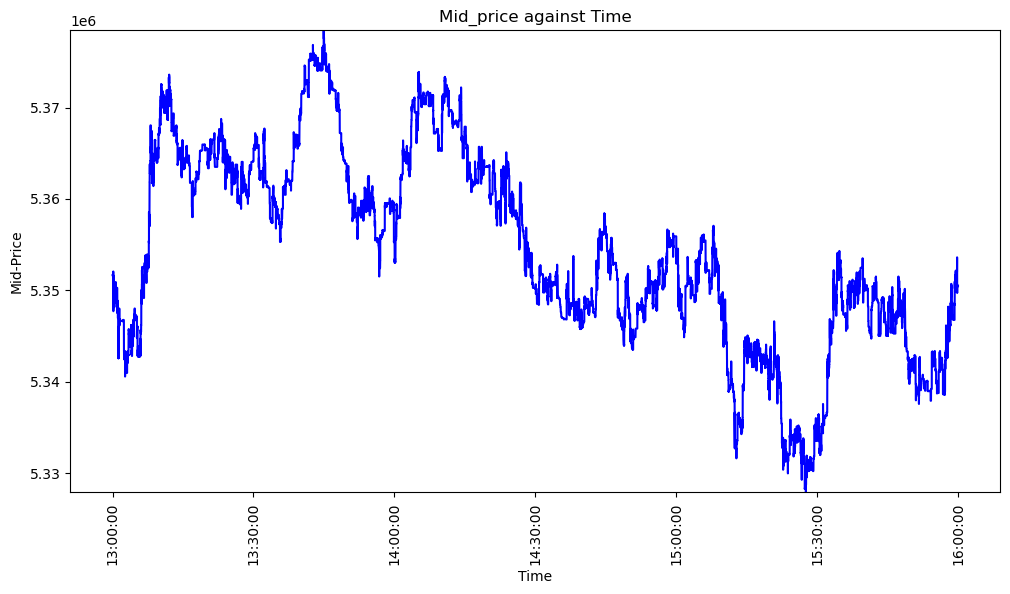

In [10]:
## Plot a chart to visualise the movement of mid-price with time
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mid-price against time
ax.plot(LOB_Amazon['Time'], LOB_Amazon['Mid_Price'], color ='blue')

# Set the x-axis label and tick format
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax.tick_params(axis ='x', rotation = 90)

plt.title('Mid_price against Time')

# Set the y-axis label and limits
ax.set_ylabel('Mid-Price')
ax.set_ylim([min(LOB_Amazon['Mid_Price']) - 10, max(LOB_Amazon['Mid_Price']) + 10])

# Show the plot
plt.show()

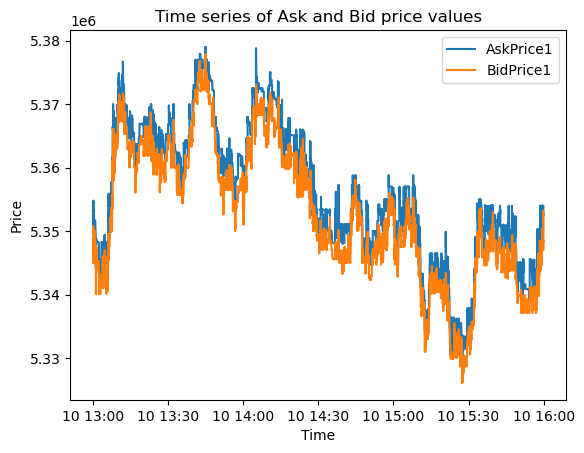

In [11]:
#plot time series for price
plt.plot(LOB_Amazon["Time"], LOB_Amazon["AskPrice1"], label="AskPrice1")
plt.plot(LOB_Amazon["Time"], LOB_Amazon["BidPrice1"], label="BidPrice1")
plt.title('Time series of Ask and Bid price values')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## 3) Data pre-processing for forecasting 

In [12]:
# Standard scaller
LOB_Amazon, SCALER = func_scale_data(LOB_Amazon.drop('Time', axis=1), t='minmax')

# To dataframe again
LOB_Amazon = pd.DataFrame(LOB_Amazon, columns = lob_cols[1:])

# extract the feature matrix, mid-price series, and forecasting variable from LOB_Amazon dataframe,
Forecasting_Variable = LOB_Amazon['Mid_Price']

# Drop the first three rows of the feature matrix using the iloc method to get rid of the Nan values
Feature_Matrix = LOB_Amazon.copy()

In [13]:
Feature_Matrix.head()

,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
0,0.469832,0.307692,0.480808,0.110397,0.46139,0.02155,0.480573,0.012405,0.475149,0.030247,...,0.481409,0.032833,0.487280,0.061914,0.469548,0.019700,0.479452,0.132755,0.461690,0.047596
1,0.469832,0.307692,0.480808,0.110397,0.46139,0.02155,0.480573,0.012405,0.475149,0.030247,...,0.481409,0.032833,0.489237,0.124453,0.469548,0.019700,0.481409,0.092728,0.461690,0.047596
2,0.469832,0.307692,0.480808,0.110397,0.46139,0.02155,0.480573,0.012405,0.475149,0.030247,...,0.457926,0.019700,0.489237,0.124453,0.459725,0.046435,0.481409,0.092728,0.442043,0.009135
3,0.469832,0.307692,0.480808,0.110397,0.46139,0.02155,0.480573,0.012405,0.475149,0.030247,...,0.477495,0.032833,0.489237,0.124453,0.469548,0.019700,0.481409,0.092728,0.461690,0.047596
4,0.469832,0.307692,0.480808,0.110397,0.46139,0.02155,0.480573,0.012405,0.475149,0.030247,...,0.477495,0.032833,0.489237,0.124453,0.475442,0.014540,0.481409,0.092728,0.471513,0.020192


## 4)  Feature Selection

In [14]:
# # Define the feature matrix
# Select a subset of the feature matrix and store in a new variable called features.
features = Feature_Matrix.iloc[7000:7050,:]

#implement the Mean Absolute Deviation (MAD) method for feature selection
mad = np.sum(np.abs(features - np.mean(features, axis=0)), axis=0) / features.shape[0]
print('Mean Absolute Deviation\n', mad)
print('-' * 20)

#implement the Correlation-based method for feature selection by computing a correlation matrix
corr_matrix = pd.DataFrame(features).corr().abs()

# Select the upper triangle of the matrix  to avoid duplicate values
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
upper = corr_matrix.where(upper_triangle)


# drop features with correlation coefficient greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('Features to Drop\n', to_drop)

Mean Absolute Deviation
 Mid_Price      0.005786
Spread         0.058015
AskPrice1      0.012003
AskVolume1     0.008085
BidPrice1      0.000811
BidVolume1     0.006966
AskPrice2      0.003714
AskVolume2     0.019649
BidPrice2      0.015698
BidVolume2     0.002790
AskPrice3      0.001419
AskVolume3     0.016339
BidPrice3      0.004023
BidVolume3     0.015678
AskPrice4      0.002700
AskVolume4     0.018148
BidPrice4      0.010134
BidVolume4     0.018723
AskPrice5      0.004615
AskVolume5     0.027731
BidPrice5      0.012642
BidVolume5     0.016913
AskPrice6      0.007094
AskVolume6     0.044213
BidPrice6      0.003598
BidVolume6     0.074079
AskPrice7      0.007090
AskVolume7     0.039124
BidPrice7      0.004999
BidVolume7     0.055295
AskPrice8      0.011194
AskVolume8     0.039124
BidPrice8      0.014860
BidVolume8     0.095032
AskPrice9      0.008914
AskVolume9     0.044728
BidPrice9      0.018483
BidVolume9     0.021974
AskPrice10     0.006046
AskVolume10    0.077662
BidPrice10     

C:\Users\adedo\AppData\Local\Temp\ipykernel_5280\2635443355.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)


In [15]:
Feature_Preserved = Feature_Matrix.copy()
Feature_Matrix = Feature_Matrix.iloc[:,1:]

## 5) LSTM (Long Short-Term Memory)Model architecture

In [16]:
#set look-back period
look_back = 10

#model architecture
modelLSTM = Sequential()
modelLSTM.add(LSTM(32, activation='relu', input_shape=(look_back, LOB_Amazon.shape[1] - 1), 
               return_sequences=True))
modelLSTM.add(Dropout(0.3, seed=42))
modelLSTM.add(LSTM(64))
modelLSTM.add(Dropout(0.3, seed=42))
modelLSTM.add(Dense(1, activation='linear'))
modelLSTM.compile(optimizer='adam',loss='mse')

# Set up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

# Set up the file handler
handler = logging.FileHandler('error.log')
handler.setLevel(logging.ERROR)

# Set up the formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

try:# LSTM Neural Network
    from sklearn.model_selection import TimeSeriesSplit

    tscv = TimeSeriesSplit()
    print(tscv)
    print(120*'#')

    counter = 0
    for train_index, test_index in tscv.split(Feature_Matrix):
        counter += 1
        print('Fold %d:' %counter)
        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = Feature_Matrix.iloc[train_index,:], Feature_Matrix.iloc[test_index,:]
        Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
        print(62*'-')


        # Prepare LSTM data - 3D Inputs of the format [samples, lookback period, features]
        # Training Dataset
        X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
        Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()
        
        x_train_append_matrix = []
        y_train_append_matrix = []

        for i in range(len(X_train)-look_back):         
            feat_current_train = X_train_to_Numpy[i:i+look_back, :]
            label_current_train = Y_train_to_Numpy[i+look_back]
            x_train_append_matrix.append(feat_current_train)
            y_train_append_matrix.append(label_current_train)

        X_train_numpy = np.array(x_train_append_matrix)
        Y_train_numpy = np.array(y_train_append_matrix)
        
        # Testing dataset
        Y_test = Y_test.values.reshape(-1,1)

        X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
        Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()

        # construct the LSTM
        def root_mean_squared_error(y_true, y_pred):
            '''
            Compute the root mean squared error (RMSE) between two arrays.

            Parameters
            ----------
            y_true : array-like of shape (n_samples,)
                Ground truth (correct) target values.

            Yt : array-like of shape (n_samples,)
                Estimated target values.(the predicted value)

            Returns
            -------
            rmse : float
                The root mean squared error between `y_true` and `y_pred`.
           '''
            return K.sqrt(K.mean(K.square(y_pred - y_true))) 

        # Fit model with history to check for overfitting
        history = modelLSTM.fit(X_train_numpy, Y_train_numpy, epochs=10, batch_size = 50000, validation_split = 0.2, shuffle=False)


        look_back = 10
        x_test_append_matrix = []
        y_test_append_matrix = []

        for i in range(len(X_test)-look_back):         
            feat_current_test = X_test_to_Numpy[i:i+look_back, :]
            label_current_test = Y_test_to_Numpy[i+look_back]
            x_test_append_matrix.append(feat_current_test)
            y_test_append_matrix.append(label_current_test)

        X_test_numpy = np.array(x_test_append_matrix)
        Y_test_numpy = np.array(y_test_append_matrix)


        predict_LSTM = modelLSTM.predict(X_test_numpy)

        from sklearn.metrics import mean_squared_error

        mse = mean_squared_error(Y_test_numpy, predict_LSTM)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_test_numpy, predict_LSTM)
        r2 = r2_score(Y_test_numpy, predict_LSTM)
        
        #print the results
        print('R-squared:', r2)
        print('MAE:', mae)
        print('MSE:', mse)
        print('RMSE:', rmse)
        print(120*'#')

        #log error if error occurs
except Exception as e:
    logger.error('An error occurred: {}'.format(str(e)))


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
########################################################################################################################
Fold 1:
TRAIN: 34918 TEST: 34913
--------------------------------------------------------------
Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 0.2948 - val_loss: 0.2401
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.1798 - val_loss: 0.1087
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0891 - val_loss: 0.0239
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.0326 - val_loss: 0.0019
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0200 - val_loss: 0.0383
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.0467 - val_loss: 0.0699
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0685 - val_loss: 0.0661
Epoch 8/10
1/1 [============================

## 6) Inverse scaling or denormalisation

In [17]:
def func_inverse(X, param1, param2, t = 'minmax'):
    '''
    Invert the scaling operation performed on a Pandas DataFrame using the specified scaler.

    Parameters
    ----------
    X : pandas.DataFrame
        A Pandas DataFrame containing the scaled data to be inverted.
    param1 : float
        The minimum value or mean value of the original data before scaling.
    param2 : float
        The scaling factor or standard deviation of the original data before scaling.
    t : str, optional
        The type of scaling to be inverted. Valid options are 'minmax' for MinMaxScaler and 'standard' for StandardScaler. Default is 'minmax'.

    Returns
    -------
    pandas.DataFrame
        A Pandas DataFrame containing the inverted data.
    '''
    yhat_norm = pd.DataFrame(X)
    
    if t == 'minmax':
        SCALE_INVERSE = MinMaxScaler()
        SCALE_INVERSE.min_ = param1
        SCALE_INVERSE.scale_ = param2
        
    else: 
        SCALE_INVERSE = StandardScaler()
        SCALE_INVERSE.mean_ = param1
        SCALE_INVERSE.scale_ = param2
        
    yhat_norm = SCALE_INVERSE.inverse_transform(yhat_norm)
    
    return yhat_norm

In [18]:
## denormalisation
predict_LSTM_inverse = func_inverse(predict_LSTM, SCALER.min_[0], SCALER.scale_[0], t = 'minmax')
Ytest_inverse = func_inverse(Y_test_to_Numpy, SCALER.min_[0], SCALER.scale_[0], t = 'minmax')

## 7) Visualisation of trend of true and predicted values against time (LSTM)

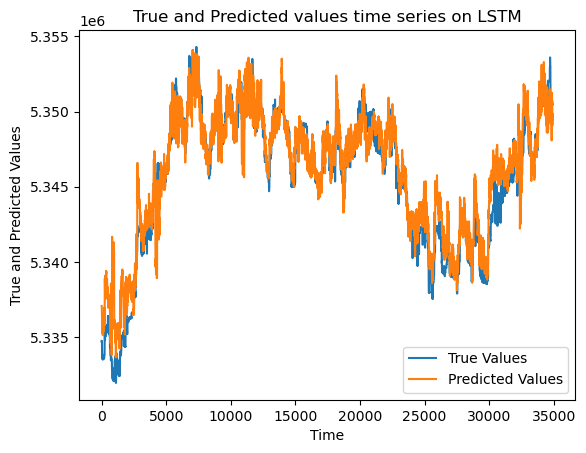

In [36]:
#define range of data to be plotted
start_index = 0
end_index = 1000

#create lines on the graph
plt.plot(Ytest_inverse.reshape(1,-1)[0][-len(predict_LSTM):], label='True Values')
plt.plot(predict_LSTM_inverse.reshape(1,-1)[0], label='Predicted Values')

#label the x and y axis
plt.xlabel('Time')
plt.ylabel('True and Predicted Values')
plt.title('True and Predicted values time series on LSTM')
#place legend in the chart
plt.legend()

#show chart
plt.show()

## 8) Predictions (LSTM)

In [20]:
# Predicting the movement of the stock
# Calculate the mean of the predicted midprice values
mean_mid_price = np.mean(predict_LSTM)

# Categorize the predicted midprice values as -1 or +1 based on relationship with the mean midprice
predictions = np.where(predict_LSTM < mean_mid_price, -1, 1)

if (predictions == mean_mid_price).any():
    print("The price is static, so the investor should hold")
elif (predictions > mean_mid_price).any():
    print("The price is rising, so the investor should Sell")
else:
    print("The The price is falling, so the investor should Buy")

The price is rising, so the investor should Sell


# 9) CNN (Convolutional Neural Network)

In [21]:
#set look-back period
look_back = 10

modelCNN = Sequential()
modelCNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back,X_train_numpy.shape[2])))
modelCNN.add(MaxPooling1D(pool_size=2))
modelCNN.add(Flatten())
modelCNN.add(Dense(100, activation='relu'))
modelCNN.add(Dense(1, activation='linear')) 
modelCNN.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Set up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

# Set up the file handler
handler = logging.FileHandler('error.log')
handler.setLevel(logging.ERROR)

# Set up the formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

try:
    # Time Series Cross Validation
    tscv = TimeSeriesSplit()
    print(tscv)
    print(120*'#')

    counter = 0
    for train_index, test_index in tscv.split(Feature_Matrix):
        counter += 1
        print('Fold %d:' %counter)
        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = Feature_Matrix.iloc[train_index,:], Feature_Matrix.iloc[test_index,:]
        Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
        print(62*'-')

        # Prepare CNN data 
        X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
        Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

        x_train_append_matrix = []
        y_train_append_matrix = []

        for i in range(len(X_train)-look_back):         
            feat_current_train = X_train_to_Numpy[i:i+look_back, :]
            label_current_train = Y_train_to_Numpy[i+look_back]
            x_train_append_matrix.append(feat_current_train)
            y_train_append_matrix.append(label_current_train)

        X_train_numpy = np.array(x_train_append_matrix)
        Y_train_numpy = np.array(y_train_append_matrix)

        # Testing dataset 
        Y_test = Y_test.values.reshape(-1,1)

        X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
        Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()

        x_test_append_matrix = []
        y_test_append_matrix = []

        for i in range(len(X_test)-look_back):         
            feat_current_test = X_test_to_Numpy[i:i+look_back, :]
            label_current_test = Y_test_to_Numpy[i+look_back]
            x_test_append_matrix.append(feat_current_test)
            y_test_append_matrix.append(label_current_test)

        X_test_numpy = np.array(x_test_append_matrix)
        Y_test_numpy = np.array(y_test_append_matrix)

        # Fit model with history to check for overfitting
        history = modelCNN.fit(X_train_numpy, Y_train_numpy, epochs=10, batch_size=50000, validation_split=0.2, shuffle=False)

        
        look_back = 10
        x_test_append_matrix = []
        y_test_append_matrix = []

        for i in range(len(X_test)-look_back):         
            feat_current_test = X_test_to_Numpy[i:i+look_back, :]
            label_current_test = Y_test_to_Numpy[i+look_back]
            x_test_append_matrix.append(feat_current_test)
            y_test_append_matrix.append(label_current_test)

        X_test_numpy = np.array(x_test_append_matrix)
        Y_test_numpy = np.array(y_test_append_matrix)

        #make predictions
        predict_CNN = modelCNN.predict(X_test_numpy)

        
        mse = mean_squared_error(Y_test_numpy, predict_CNN)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_test_numpy, predict_CNN)
        r2 = r2_score(Y_test_numpy, predict_CNN)
        
        #print results
        print('R-squared:', r2)
        print('MAE:', mae)
        print('MSE:', mse)
        print('RMSE:', rmse)
        print(120*'#')
        
#log error if errors occur
except Exception as e:
    logger.error('An error occurred: {}'.format(str(e)))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
########################################################################################################################
Fold 1:
TRAIN: 34918 TEST: 34913
--------------------------------------------------------------
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.9850 - mse: 0.9850 - val_loss: 0.4197 - val_mse: 0.4197
Epoch 2/10
1/1 [==============================] - 0s 388ms/step - loss: 0.2803 - mse: 0.2803 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 3/10
1/1 [==============================] - 0s 404ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0786 - val_mse: 0.0786
Epoch 4/10
1/1 [==============================] - 0s 389ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 0.2205 - val_mse: 0.2205
Epoch 5/10
1/1 [==============================] - 0s 404ms/step - loss: 0.1826 - mse: 0.1826 - val_loss: 0.2494 - val_mse: 0.2494
Epoch 6/10
1/1 [==============================] - 1s 516ms/step 

3/3 [==============================] - 2s 724ms/step - loss: 6.1027e-04 - mse: 6.1027e-04 - val_loss: 5.0122e-04 - val_mse: 5.0122e-04
Epoch 9/10
3/3 [==============================] - 2s 685ms/step - loss: 4.9091e-04 - mse: 4.9091e-04 - val_loss: 5.1062e-04 - val_mse: 5.1062e-04
Epoch 10/10
1091/1091 [==============================] - 4s 3ms/step
R-squared: 0.955670622800729
MAE: 0.015093483924276006
MSE: 0.0003941111340693536
RMSE: 0.019852232470665702
########################################################################################################################


## 10) Inverse scaling or denormalisation (CNN)

In [22]:
def func_inverse(X, param1, param2, t = 'minmax'):
    '''
    Invert the scaling operation performed on a Pandas DataFrame using the specified scaler.

    Parameters
    ----------
    X : pandas.DataFrame
        A Pandas DataFrame containing the scaled data to be inverted.
    param1 : float
        The minimum value or mean value of the original data before scaling.
    param2 : float
        The scaling factor or standard deviation of the original data before scaling.
    t : str, optional
        The type of scaling to be inverted. Valid options are 'minmax' for MinMaxScaler and 'standard' for StandardScaler. Default is 'minmax'.

    Returns
    -------
    pandas.DataFrame
        A Pandas DataFrame containing the inverted data.
    '''
    yhat_norm = pd.DataFrame(X)
    
    if t == 'minmax':
        SCALE_INVERSE = MinMaxScaler()
        SCALE_INVERSE.min_ = param1
        SCALE_INVERSE.scale_ = param2
        
    else: 
        SCALE_INVERSE = StandardScaler()
        SCALE_INVERSE.mean_ = param1
        SCALE_INVERSE.scale_ = param2
        
    yhat_norm = SCALE_INVERSE.inverse_transform(yhat_norm)
    
    return yhat_norm

In [23]:
#denormalisation
predict_CNN_inverse = func_inverse(predict_CNN, SCALER.min_[0], SCALER.scale_[0], t = 'minmax')
Ytest_inverse = func_inverse(Y_test_to_Numpy, SCALER.min_[0], SCALER.scale_[0], t = 'minmax')

## CNN visualisation

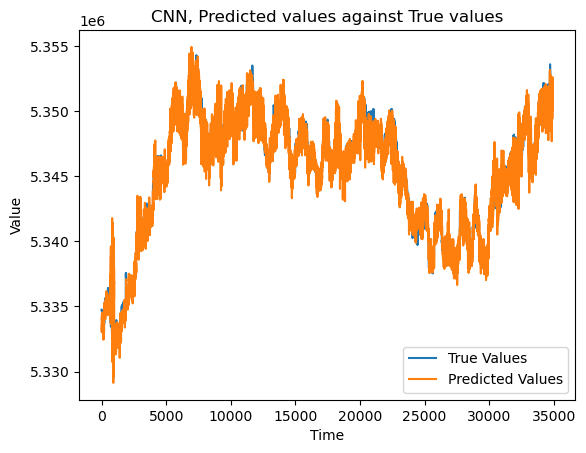

In [24]:
import matplotlib.pyplot as plt

#set up range to be plotted
start_index = 0
end_index = 1000

#plot chart for CNN values
plt.plot(Ytest_inverse.reshape(1,-1)[0][-len(predict_CNN):], label='True Values')
plt.plot(predict_CNN_inverse.reshape(1,-1)[0], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')

plt.title('CNN, Predicted values against True values')
plt.legend()
plt.show()

In [25]:
#Create threshold to predict direction of price

predicted_prices = predict_CNN
threshold = np.mean(predict_CNN)  # Threshold to determine direction

predicted_directions = []
for price in predicted_prices:
    if price > threshold:
        predicted_directions.append(1)  # Upward trend
        print("The price is rising, so the investor should Sell")
    elif price < threshold:
        predicted_directions.append(-1) # Downward trend
        ("The The price is falling, so the investor should Buy")
    else:
        predicted_directions.append(0)  #static price
        print("The price is static, so the investor should hold")
print(predicted_directions)

The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising, so the investor should Sell
The price is rising,

## 11)  GRU(Gated recurrent Unit)

In [26]:
#set up look-back period
look_back = 10

modelGRU = Sequential()
modelGRU.add(GRU(units=64, input_shape=(look_back,X_train_numpy.shape[2])))
modelGRU.add(Flatten())
modelGRU.add(Dense(100, activation='relu'))
modelGRU.add(Dense(1, activation='linear')) 
modelGRU.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Set up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

# Set up the file handler
handler = logging.FileHandler('error.log')
handler.setLevel(logging.ERROR)

# Set up the formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

try:
    # Time Series Cross Validation
    tscv = TimeSeriesSplit()
    print(tscv)
    print(120*'#')

    counter = 0
    for train_index, test_index in tscv.split(Feature_Matrix):
        counter += 1
        print('Fold %d:' %counter)
        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = Feature_Matrix.iloc[train_index,:], Feature_Matrix.iloc[test_index,:]
        Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
        print(62*'-')

        # Prepare GRU data - 3D Inputs of the format [samples, lookback period, features]
        X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
        Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

        x_train_append_matrix = []
        y_train_append_matrix = []

        for i in range(len(X_train)-look_back):         
            feat_current_train = X_train_to_Numpy[i:i+look_back, :]
            label_current_train = Y_train_to_Numpy[i+look_back]
            x_train_append_matrix.append(feat_current_train)
            y_train_append_matrix.append(label_current_train)

        X_train_numpy = np.array(x_train_append_matrix)
        Y_train_numpy = np.array(y_train_append_matrix)

        # Testing dataset 
        Y_test = Y_test.values.reshape(-1,1)

        X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
        Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()

        x_test_append_matrix = []
        y_test_append_matrix = []

        for i in range(len(X_test)-look_back):         
            feat_current_test = X_test_to_Numpy[i:i+look_back, :]
            label_current_test = Y_test_to_Numpy[i+look_back]
            x_test_append_matrix.append(feat_current_test)
            y_test_append_matrix.append(label_current_test)

        X_test_numpy = np.array(x_test_append_matrix)
        Y_test_numpy = np.array(y_test_append_matrix)

        # Fit model with history to check for overfitting
        history = modelGRU.fit(X_train_numpy, Y_train_numpy, epochs=10, batch_size=50000, validation_split=0.2, shuffle=False)

        look_back = 10
        x_test_append_matrix = []
        y_test_append_matrix = []

        for i in range(len(X_test)-look_back):         
            feat_current_test = X_test_to_Numpy[i:i+look_back, :]
            label_current_test = Y_test_to_Numpy[i+look_back]
            x_test_append_matrix.append(feat_current_test)
            y_test_append_matrix.append(label_current_test)

        X_test_numpy = np.array(x_test_append_matrix)
        Y_test_numpy = np.array(y_test_append_matrix)


        predict_GRU = modelGRU.predict(X_test_numpy)

        from sklearn.metrics import mean_squared_error

        mse = mean_squared_error(Y_test_numpy, predict_GRU)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_test_numpy, predict_GRU)
        r2 = r2_score(Y_test_numpy, predict_GRU)
        
        #print the results
        print('R-squared:', r2)
        print('MAE:', mae)
        print('MSE:', mse)
        print('RMSE:', rmse)
        print(120*'#')

        #log errors where they occur
except Exception as e:
    logger.error('An error occurred: {}'.format(str(e)))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
########################################################################################################################
Fold 1:
TRAIN: 34918 TEST: 34913
--------------------------------------------------------------
Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.2154 - mse: 0.2154 - val_loss: 0.1063 - val_mse: 0.1063
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0697 - mse: 0.0697 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0500 

3/3 [==============================] - 7s 2s/step - loss: 2.4394e-04 - mse: 2.4394e-04 - val_loss: 5.2104e-04 - val_mse: 5.2104e-04
Epoch 9/10
3/3 [==============================] - 8s 3s/step - loss: 2.4096e-04 - mse: 2.4096e-04 - val_loss: 5.4282e-04 - val_mse: 5.4282e-04
Epoch 10/10
1091/1091 [==============================] - 6s 5ms/step
R-squared: 0.9723396380000112
MAE: 0.01254474602314008
MSE: 0.00024591495133307885
RMSE: 0.01568167565450449
########################################################################################################################


In [27]:
def func_inverse(X, param1, param2, t = 'minmax'):
    '''
    Invert the scaling operation performed on a Pandas DataFrame using the specified scaler.

    Parameters
    ----------
    X : pandas.DataFrame
        A Pandas DataFrame containing the scaled data to be inverted.
    param1 : float
        The minimum value or mean value of the original data before scaling.
    param2 : float
        The scaling factor or standard deviation of the original data before scaling.
    t : str, optional
        The type of scaling to be inverted. Valid options are 'minmax' for MinMaxScaler and 'standard' for StandardScaler. Default is 'minmax'.

    Returns
    -------
    pandas.DataFrame
        A Pandas DataFrame containing the inverted data.
    '''
    yhat_norm = pd.DataFrame(X)
    
    if t == 'minmax':
        SCALE_INVERSE = MinMaxScaler()
        SCALE_INVERSE.min_ = param1
        SCALE_INVERSE.scale_ = param2
        
    else: 
        SCALE_INVERSE = StandardScaler()
        SCALE_INVERSE.mean_ = param1
        SCALE_INVERSE.scale_ = param2
        
    yhat_norm = SCALE_INVERSE.inverse_transform(yhat_norm)
    
    return yhat_norm

In [28]:
predict_GRU_inverse = func_inverse(predict_GRU, SCALER.min_[0], SCALER.scale_[0], t = 'minmax')
Ytest_inverse = func_inverse(Y_test_to_Numpy, SCALER.min_[0], SCALER.scale_[0], t = 'minmax')

## 12)  GRU Visualisation

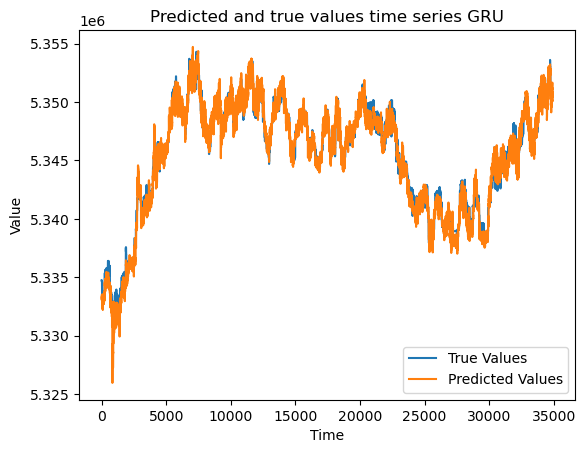

In [37]:
import matplotlib.pyplot as plt

start_index = 0
end_index = 1000

plt.plot(Ytest_inverse.reshape(1,-1)[0][-len(predict_GRU):], label='True Values')
plt.plot(predict_GRU_inverse.reshape(1,-1)[0], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')

plt.title('Predicted and true values time series GRU')
plt.legend()
plt.show()

# 13) Ensemble

In [30]:
#Averaging
# train a sequential LSTM model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelLSTM.fit(X_train_numpy,Y_train_numpy)
# train a sequential CNN model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelCNN.fit(X_train_numpy,Y_train_numpy)
# train a sequential GRU model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelGRU.fit(X_train_numpy,Y_train_numpy)

#generate predictions for the test data X_test_numpy using the trained LSTM model modelLSTM
predict_LSTM = modelLSTM.predict(X_test_numpy)
#generate predictions for the test data X_test_numpy using the trained CNN model modelCNN
predict_CNN = modelCNN.predict(X_test_numpy)
#generate predictions for the test data X_test_numpy using the trained GRU model modelGRU
predict_GRU = modelGRU.predict(X_test_numpy)

#combine the predictions from the three models by averaging them, and store the resulting predictions in final_pred
final_pred=(predict_LSTM + predict_CNN + predict_GRU)/3

1091/1091 [==============================] - 5s 5ms/step


In [31]:
### weighted average

# train a sequential LSTM model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelLSTM.fit(X_train_numpy,Y_train_numpy)
# train a sequential CNN model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelCNN.fit(X_train_numpy,Y_train_numpy)
# train a sequential GRU model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelGRU.fit(X_train_numpy,Y_train_numpy)


#generate predictions for the test data X_test_numpy using the trained LSTM model modelLSTM
predict_LSTM = modelLSTM.predict(X_test_numpy)
#generate predictions for the test data X_test_numpy using the trained CNN model modelCNN
predict_CNN = modelCNN.predict(X_test_numpy)
#generate predictions for the test data X_test_numpy using the trained GRU model modelGRU
predict_GRU = modelGRU.predict(X_test_numpy)

final_pred=(predict_LSTM * 0.3 + predict_CNN * 0.3 + predict_GRU * 0.4)

1091/1091 [==============================] - 5s 5ms/step


In [32]:
## Max fitting
#from statistics import mode

from scipy.stats import mode


# train a sequential LSTM model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelLSTM.fit(X_train_numpy,Y_train_numpy)
# train a sequential CNN model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelCNN.fit(X_train_numpy,Y_train_numpy)
# train a sequential GRU model using the training data X_train_numpy and the corresponding label Y_train_numpy
modelGRU.fit(X_train_numpy,Y_train_numpy)

#generate predictions for the test data X_test_numpy using the trained LSTM model modelLSTM
predict_LSTM = modelLSTM.predict(X_test_numpy)
#generate predictions for the test data X_test_numpy using the trained CNN model modelCNN
predict_CNN = modelCNN.predict(X_test_numpy)
#generate predictions for the test data X_test_numpy using the trained GRU model modelGRU
predict_GRU = modelGRU.predict(X_test_numpy)

final_pred = np.array([])
for i in range(len(X_test_numpy)):
    pred_list = [predict_LSTM[i], predict_CNN[i], predict_GRU[i]]
    pred_list = [x.tolist()[0] for x in pred_list]
    final_pred = np.append(final_pred, mode(pred_list)[0])

1091/1091 [==============================] - 6s 5ms/step


C:\Users\adedo\AppData\Local\Temp\ipykernel_5280\1752453673.py:25: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred = np.append(final_pred, mode(pred_list)[0])


Epoch 1/10
4364/4364 [==============================] - 87s 20ms/step - loss: 3.0790e-04 - val_loss: 0.0048
Epoch 2/10
4364/4364 [==============================] - 88s 20ms/step - loss: 2.9044e-04 - val_loss: 0.0457
Epoch 3/10
4364/4364 [==============================] - 89s 20ms/step - loss: 2.8534e-04 - val_loss: 0.0472
Epoch 4/10
4364/4364 [==============================] - 90s 21ms/step - loss: 2.7783e-04 - val_loss: 0.0562
Epoch 5/10
4364/4364 [==============================] - 59s 14ms/step - loss: 2.7646e-04 - val_loss: 0.0418
Epoch 6/10
4364/4364 [==============================] - 59s 13ms/step - loss: 2.6997e-04 - val_loss: 0.0470
Epoch 7/10
4364/4364 [==============================] - 64s 15ms/step - loss: 2.6703e-04 - val_loss: 0.0421
Epoch 8/10
4364/4364 [==============================] - 61s 14ms/step - loss: 2.6329e-04 - val_loss: 0.0814
Epoch 9/10
4364/4364 [==============================] - 66s 15ms/step - loss: 2.5934e-04 - val_loss: 0.0960
Epoch 10/10
4364/4364 [=====

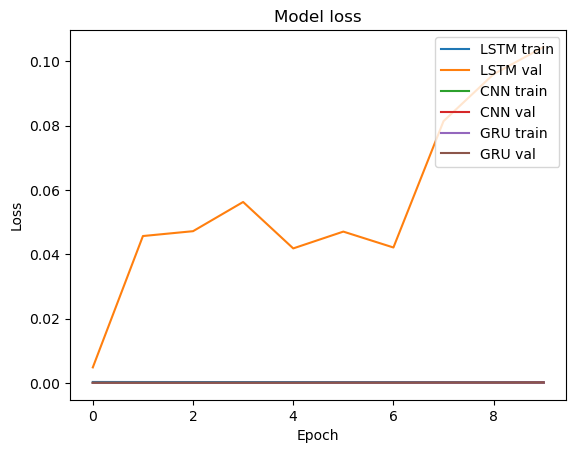

In [33]:
import matplotlib.pyplot as plt

# Train the models and save the history during the training process
history_LSTM = modelLSTM.fit(X_train_numpy, Y_train_numpy, validation_split=0.2, epochs=10)
history_CNN = modelCNN.fit(X_train_numpy, Y_train_numpy, validation_split=0.2, epochs=10)
history_GRU = modelGRU.fit(X_train_numpy, Y_train_numpy, validation_split=0.2, epochs=10)

#Model performance chart
# Plot training & validation loss values
plt.plot(modelLSTM.history.history['loss'])
plt.plot(modelLSTM.history.history['val_loss'])
plt.plot(modelCNN.history.history['loss'])
plt.plot(modelCNN.history.history['val_loss'])
plt.plot(modelGRU.history.history['loss'])
plt.plot(modelGRU.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM train', 'LSTM val', 'CNN train', 'CNN val', 'GRU train', 'GRU val'], loc='upper right')
plt.show()


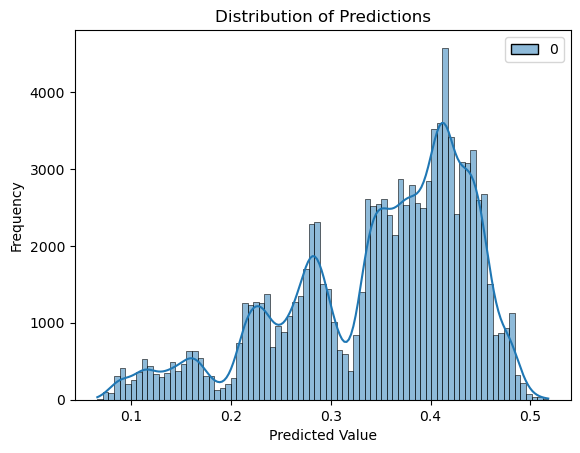

In [34]:
#Prediction distribution chart

import seaborn as sns

# Combine predictions into a single array
all_predictions = np.concatenate([predict_LSTM, predict_CNN, predict_GRU])

# Create histogram of predictions
sns.histplot(all_predictions, kde=True)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.show()



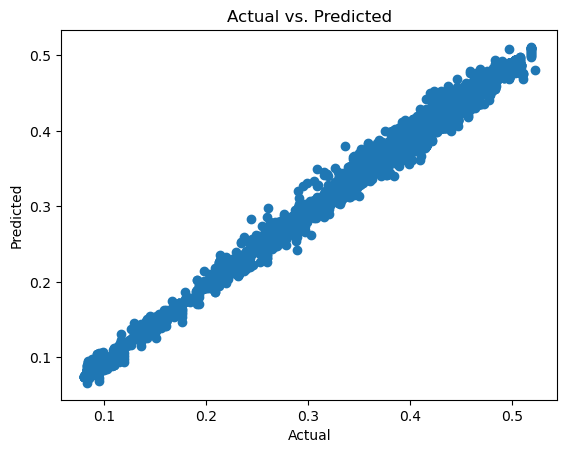

In [35]:
#Actual vs. predicted chart

# Create scatter plot of actual vs. predicted values
plt.scatter(Y_test_numpy, final_pred)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


## References

scikit-learn. (n.d.). Examples. [online] Available at: https://scikit-learn.org/stable/auto_examples/index.html#examples.

‌Team, K. (n.d.). Keras documentation: Getting started. [online] keras.io. Available at: https://keras.io/getting_started/.

‌Adam Ntakaris, seminar 4, Ensemble learning, financial machine learning II practical(CMSE 11528), University of Edinburgh, delivered on March 22, 2023.

Adam Ntakaris, seminar 5, CNN forecasting, financial machine learning II practical(CMSE 11528), University of Edinburgh, delivered on March 29, 2023.

Adam Ntakaris, seminar 5, LSTM forecasting, financial machine learning II practical(CMSE 11528), University of Edinburgh, delivered on March 29, 2023.

Nair, A. (2019). How To Code Your First LSTM Network In Keras. [online] Analytics India Magazine. Available at: https://analyticsindiamag.com/how-to-code-your-first-lstm-network-in-keras/ [Accessed 17 Apr. 2023].

‌Brownlee, J. (2018). How to Develop LSTM Models for Time Series Forecasting. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/.

‌